In [1]:
import os
import warnings
import time
import threading
import seaborn as sns
from sklearn.metrics import mean_squared_error
from source.jabba import JABBA
from software.qabba import QABBA
from fABBA import fABBA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from source.ABBA import ABBA
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('bmh')
np.random.seed(42)

In [2]:
num = 100000
mu, sigma = 0, 1
tol, alpha = 0.01, 0.05

synthetic_ts = float(np.float32(np.random.normal(mu, sigma, num)))
#synthetic_ts = (synthetic_ts - synthetic_ts.mean()) / synthetic_ts.std()
#plt.figure(figsize=(22,5))
#plt.plot(synthetic_ts[:100])
#plt.show()

In [3]:
# time.sleep(5)
partition_num = threading.active_count()
print("Available threads:", partition_num)

Available threads: 8


In [4]:
start = time.time()
fabba = fABBA(tol=tol, alpha=alpha, sorting='norm', scl=1, verbose=0, return_list=True) 
symbols_fabba = fabba.fit_transform(synthetic_ts)
reconstruction_fabba = fabba.inverse_transform(symbols_fabba, synthetic_ts[0])
fabba.parameters.centers = np.float32(fabba.parameters.centers)
end = time.time()
time_cost_fabba = end - start
compression_rate_fabba = 1 - fabba.parameters.centers.shape[0]/len(synthetic_ts)
num_symbols_fabba = len(np.unique(symbols_fabba))
error_fABBA = mean_squared_error(synthetic_ts, reconstruction_fabba)
print("time:", time_cost_fabba)
print("the number of symbols used:", num_symbols_fabba)
print("MSE:", error_fABBA)

time: 26.789849519729614
the number of symbols used: 358
MSE: 7.497356241523238


In [5]:
time.sleep(5)
start = time.time()
abba = ABBA(tol=tol, scl=1, min_k=num_symbols_fabba, max_k=num_symbols_fabba, norm=2)
symbols_abba, centers = abba.transform(synthetic_ts)
reconstruction_abba = abba.inverse_transform(symbols_abba, np.float32(centers), synthetic_ts[0])
end = time.time()
time_cost_abba = end - start
compression_rate_abba = 1 - centers.shape[0]/len(synthetic_ts)
error_ABBA = mean_squared_error(synthetic_ts, reconstruction_abba)
num_symbols_fabba = num_symbols_fabba 
print("time:", time_cost_abba)
print("MSE:", error_ABBA)

Digitization: Using 358 symbols
time: 126.08115077018738
MSE: 4.271889238309245


--- Partition: 1
Runtime: 27.078649044036865
The number of symbols used: 358
MSE: 20.874270582694184
Runtime: 89.17474889755249
The number of symbols used: 358
MSE: 8.078448287030884


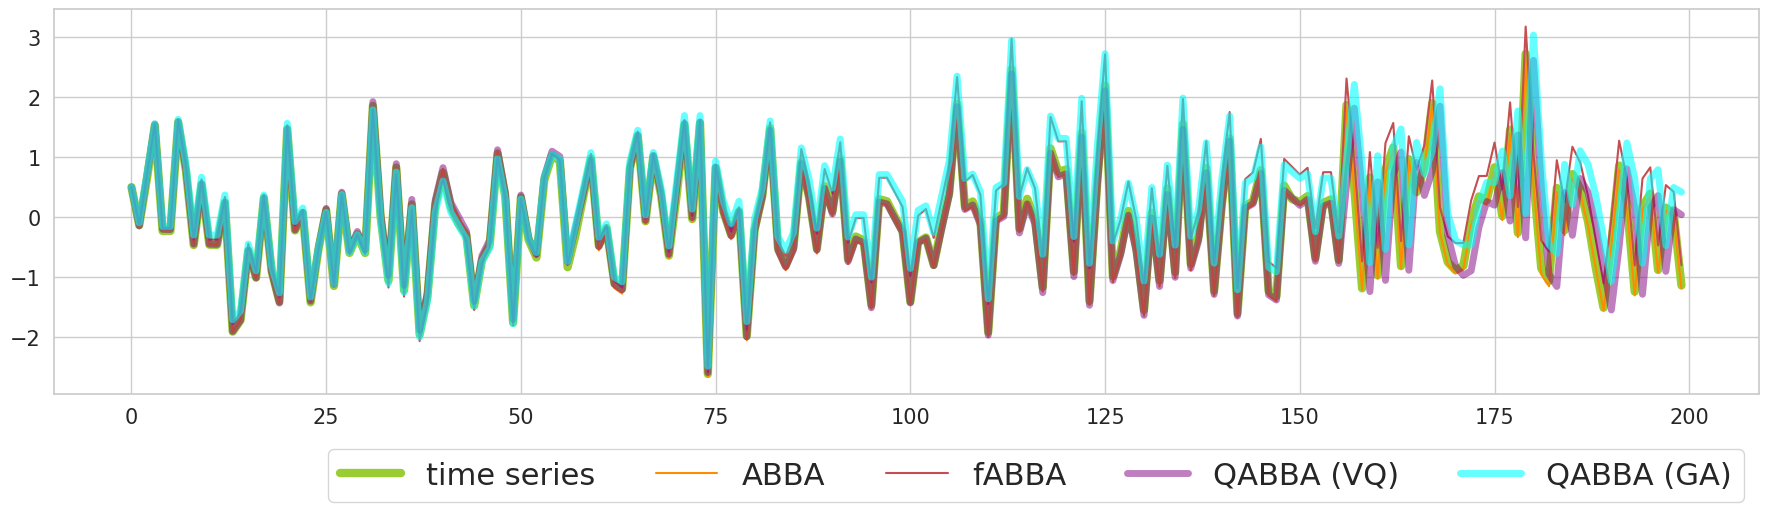

--- Partition: 2
Runtime: 15.385366201400757
The number of symbols used: 358
MSE: 11.212050617491139
Runtime: 75.06878089904785
The number of symbols used: 358
MSE: 2.6741537615719193


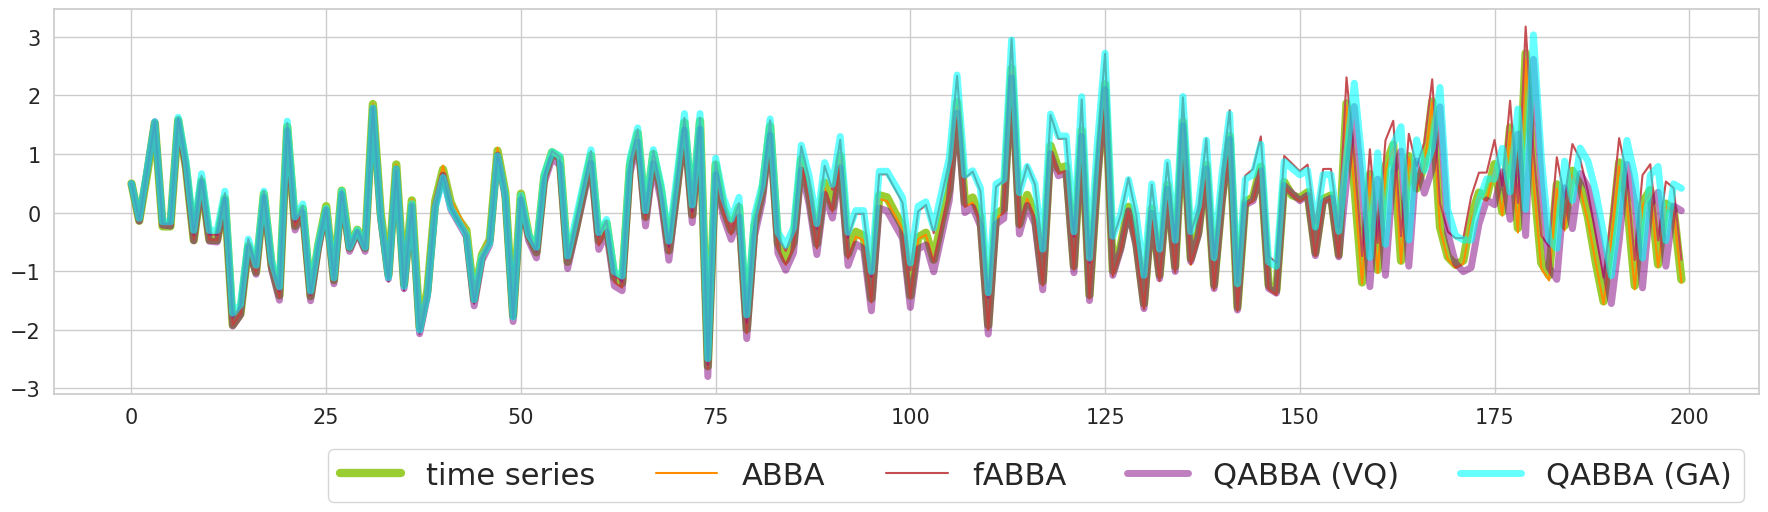

--- Partition: 3
Runtime: 10.609715223312378
The number of symbols used: 358
MSE: 16.897589712778796
Runtime: 74.31976628303528
The number of symbols used: 358
MSE: 11.307020820026276


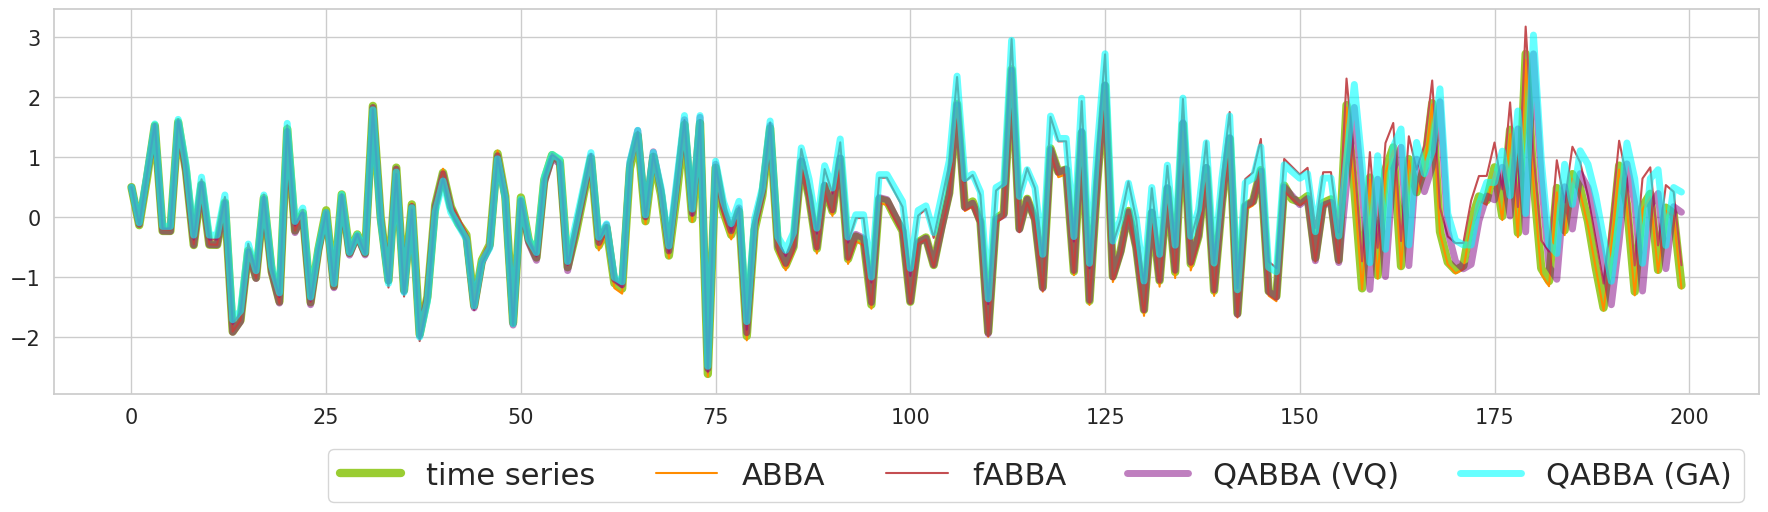

--- Partition: 4
Runtime: 7.314136028289795
The number of symbols used: 358
MSE: 10.733969518488975
Runtime: 68.22579431533813
The number of symbols used: 358
MSE: 5.229054919553361


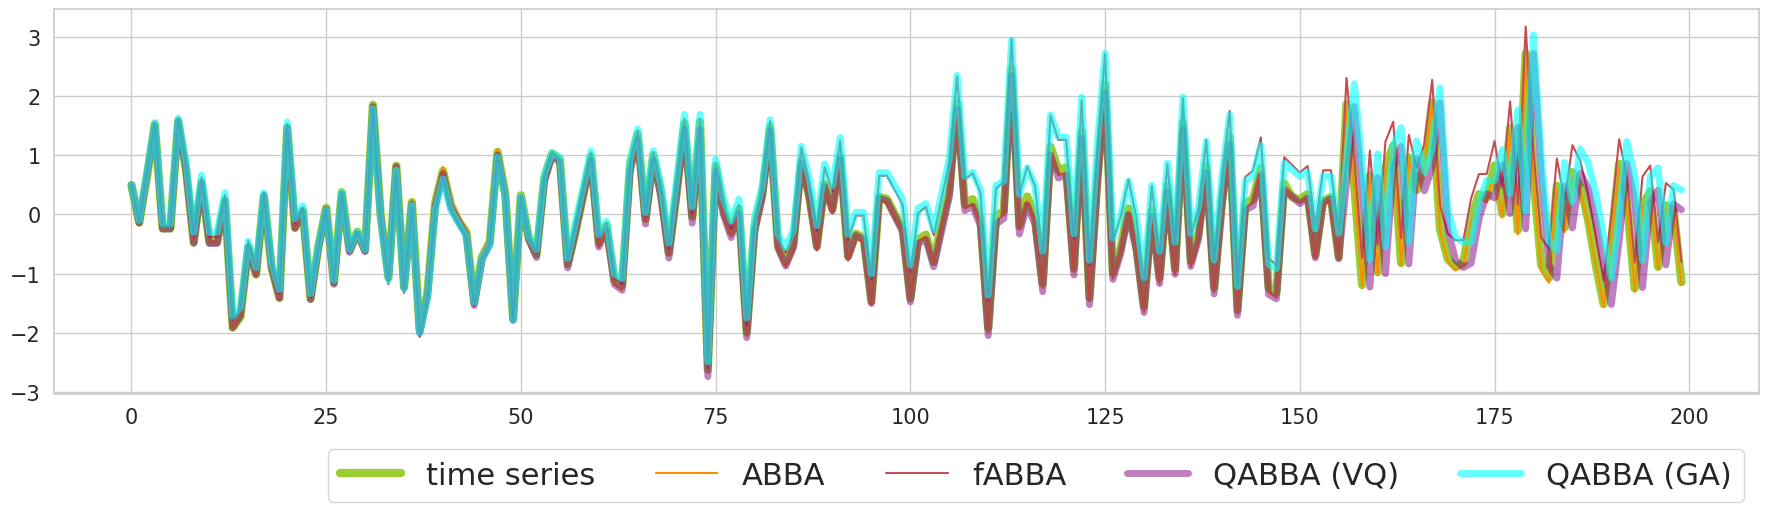

--- Partition: 5
Runtime: 6.042076110839844
The number of symbols used: 358
MSE: 7.9450609496488935
Runtime: 69.11388945579529
The number of symbols used: 358
MSE: 2.7612149452692107


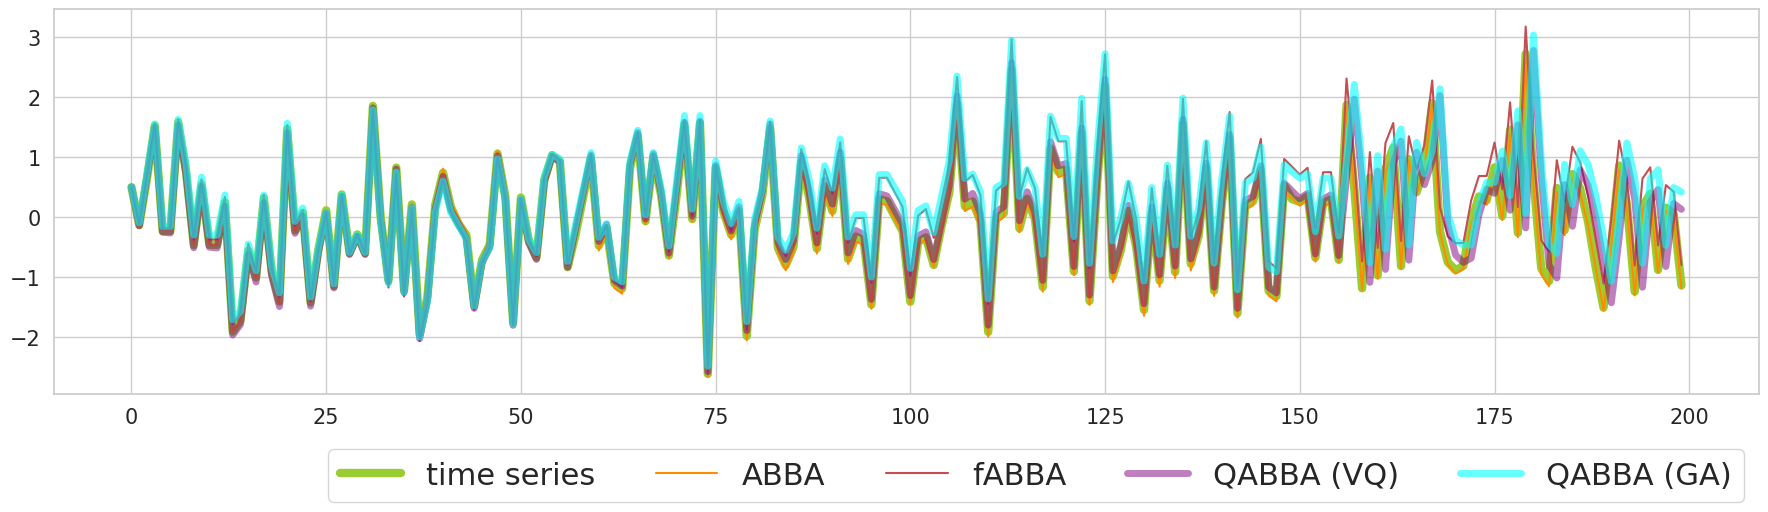

--- Partition: 6
Runtime: 5.002226829528809
The number of symbols used: 358
MSE: 8.897160706636152
Runtime: 65.69131875038147
The number of symbols used: 358
MSE: 2.795603427917961


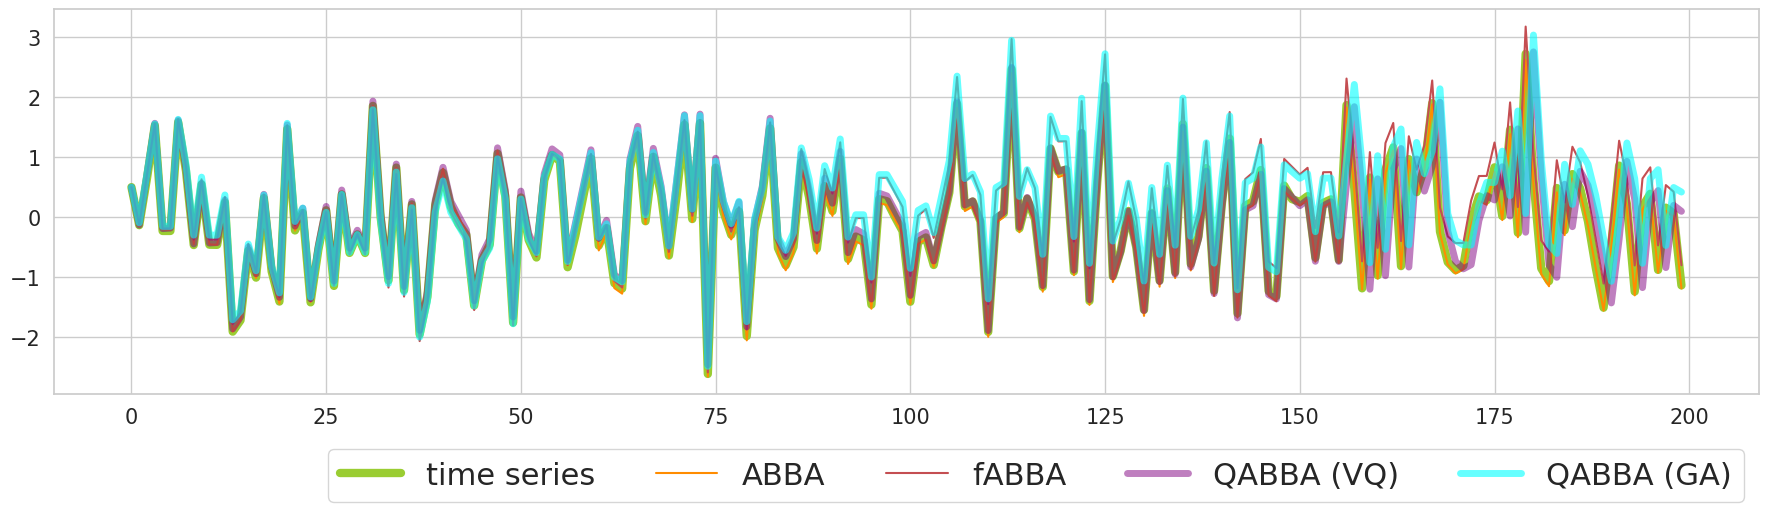

--- Partition: 7
Runtime: 4.720546245574951
The number of symbols used: 358
MSE: 7.3818194426498165
Runtime: 66.91133999824524
The number of symbols used: 358
MSE: 3.6227384181688707


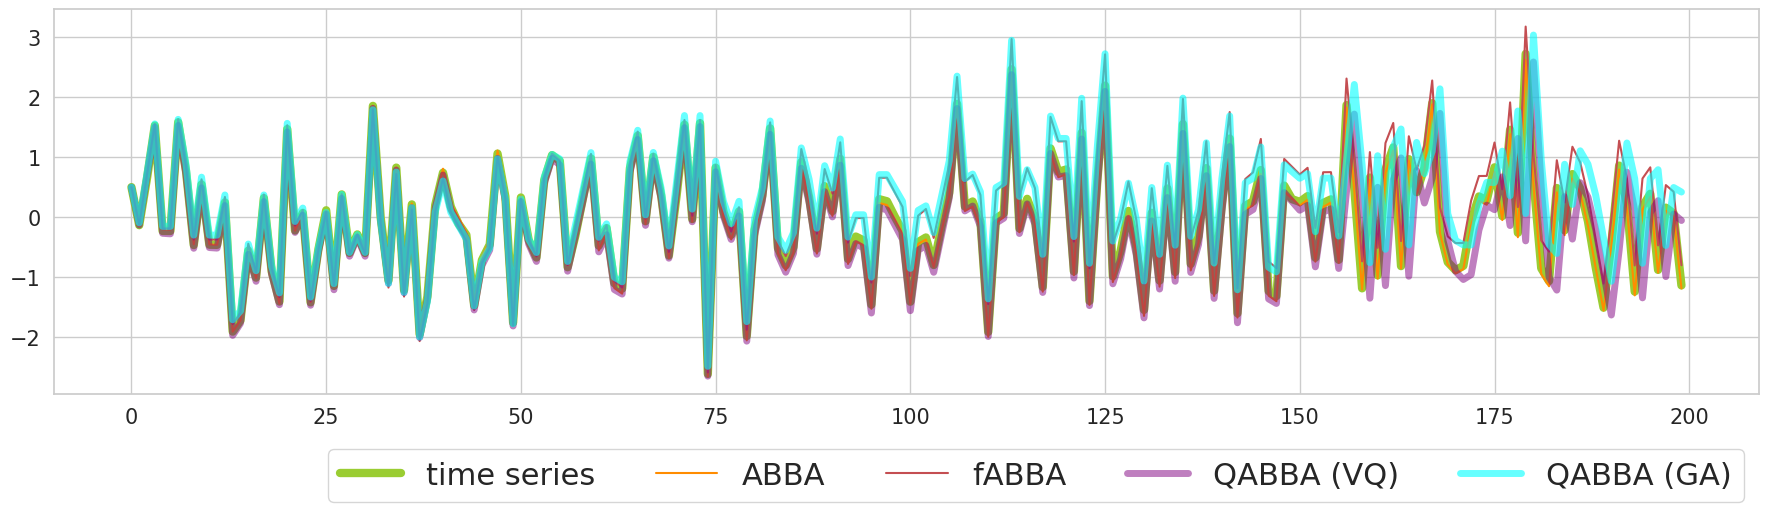

--- Partition: 8
Runtime: 4.2555201053619385
The number of symbols used: 358
MSE: 6.687848973041768
Runtime: 62.53953671455383
The number of symbols used: 358
MSE: 3.203678961921279


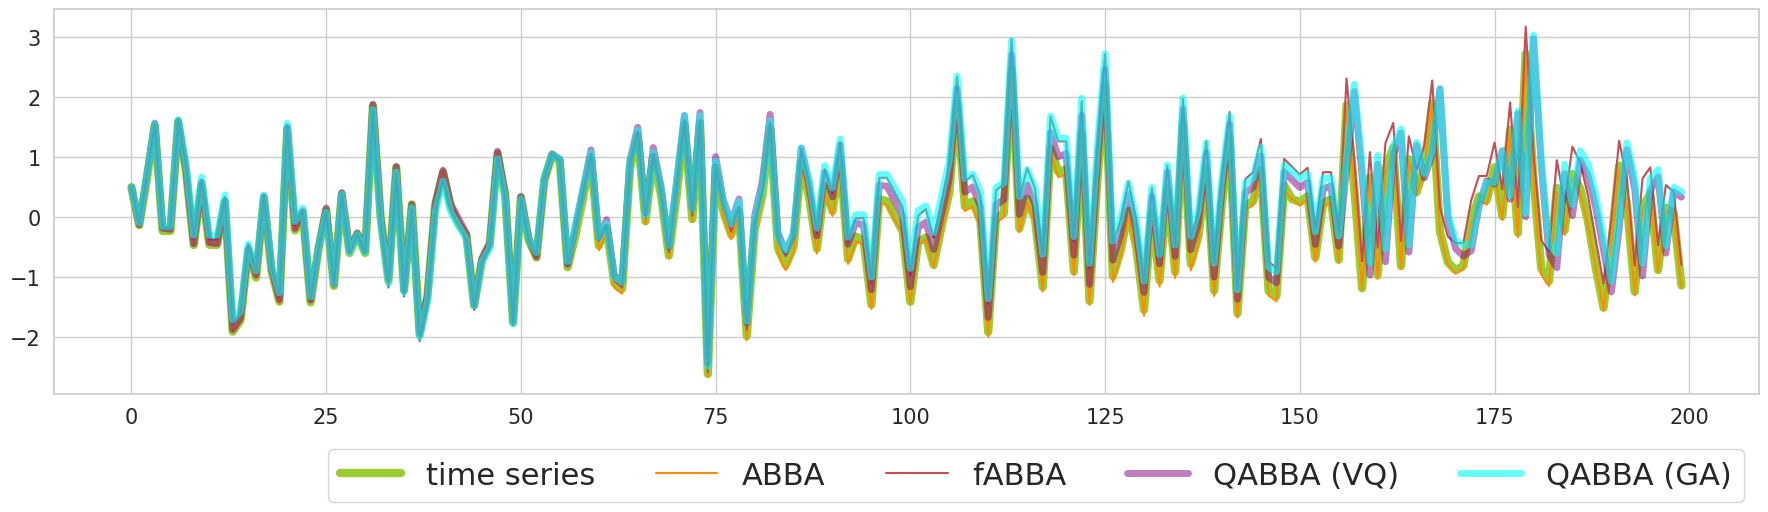

In [6]:
reconstruction_pabba1_list = list()
time_cost_pabba1_list = list()
compression_rate_pabba1_list = list()
num_symbols_pabba1_list = list()
mse_pabba1_list = list()

reconstruction_pabba2_list = list()
time_cost_pabba2_list = list()
compression_rate_pabba2_list = list()
num_symbols_pabba2_list = list()
mse_pabba2_list = list()

for i in range(1, partition_num + 1):
    print("--- Partition:", i)
    
    start = time.time()
    pabba = QABBA(tol=tol, alpha=alpha, init="agg", bits_for_len=8, bits_for_inc=12, auto_digitize=False, partition=i, verbose=0)
    symbols_pabba = pabba.fit_transform(synthetic_ts, n_jobs=i)
    reconstruction_pabba1 = pabba.inverse_transform(symbols_pabba, n_jobs=i)
    end = time.time()
    time_cost = end - start
    compression_rate = 1 - pabba.parameters.centers.shape[0]/len(synthetic_ts)
    num_symbols = len(np.unique(np.hstack(symbols_pabba)))
    minlen = min(len(reconstruction_pabba1), len(synthetic_ts))
    error_pabba = mean_squared_error(synthetic_ts[:minlen], reconstruction_pabba1[:minlen])
    print("Runtime:", time_cost)
    print("The number of symbols used:", num_symbols)
    print("MSE:", error_pabba)
    reconstruction_pabba1_list.append(reconstruction_pabba1)
    time_cost_pabba1_list.append(time_cost)
    compression_rate_pabba1_list.append(compression_rate)
    num_symbols_pabba1_list.append(num_symbols)
    mse_pabba1_list.append(error_pabba)
    
    
    start = time.time()
    pabba = QABBA(tol=tol, k=num_symbols, init="kmeans", bits_for_len=8, bits_for_inc=12, partition=i, verbose=0)
    symbols_pabba = pabba.fit_transform(synthetic_ts, n_jobs=i)
    reconstruction_pabba2 = pabba.inverse_transform(symbols_pabba, n_jobs=i)
    end = time.time()
    time_cost = end - start
    compression_rate = 1 - pabba.parameters.centers.shape[0]/len(synthetic_ts)
    num_symbols = len(np.unique(np.hstack(symbols_pabba)))
    minlen = min(len(reconstruction_pabba2), len(synthetic_ts))
    error_pabba = mean_squared_error(synthetic_ts[:minlen], reconstruction_pabba2[:minlen])
    print("Runtime:", time_cost)
    print("The number of symbols used:", num_symbols)
    print("MSE:", error_pabba)
    reconstruction_pabba2_list.append(reconstruction_pabba2)
    time_cost_pabba2_list.append(time_cost)
    compression_rate_pabba2_list.append(compression_rate)
    num_symbols_pabba2_list.append(num_symbols)
    mse_pabba2_list.append(error_pabba)

    plt.style.use("bmh")
    plt.figure(figsize=(22,5))
    sns.set(font_scale=2, style="whitegrid")
    plt.rcParams['axes.facecolor'] = 'white'

    plt.plot(synthetic_ts[:200],c='yellowgreen', linewidth=6, label="time series")
    plt.plot(reconstruction_abba[:200],  c='darkorange', label="ABBA")
    plt.plot(reconstruction_fabba[:200], c='r', label="fABBA")
    plt.plot(reconstruction_pabba2[:200], c='purple', linewidth=5, alpha=0.5, label="QABBA (VQ)")
    plt.plot(reconstruction_pabba1[:200], c='cyan', linewidth=5, alpha=0.6, label="QABBA (GA)")
    plt.legend(ncols=5, loc='lower right', bbox_to_anchor=(0.5, -0.32, 0.5, 0.5))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)

    plt.savefig('figs/partition_' + str(i) + '.pdf')
    plt.show()

In [7]:
records_pabba1 = np.vstack((np.vstack((np.vstack((time_cost_pabba1_list, compression_rate_pabba1_list)),
                                       num_symbols_pabba1_list)), mse_pabba1_list))

records_pabba2 = np.vstack((np.vstack((np.vstack((time_cost_pabba2_list, compression_rate_pabba2_list)),
                                       num_symbols_pabba2_list)), mse_pabba2_list))

records_abba = np.array([time_cost_abba, compression_rate_abba, num_symbols_fabba, error_ABBA]) 
records_fabba = np.array([time_cost_fabba, compression_rate_fabba, num_symbols_fabba, error_fABBA]) 

records = np.hstack((records_abba.reshape(-1,1), records_fabba.reshape(-1,1)))
records = np.hstack((records_pabba1, records))
records = np.hstack((records_pabba2, records))


In [8]:
partition_num
records = pd.DataFrame(records)
records.index = ["runtime", "compression rate", "symbols", "mse"]
col_names = list()

for i in range(1, partition_num  + 1):
    col_names.append("QABBA (VQ) partition="+str(i))
    
for i in range(partition_num  + 1, 2*partition_num  + 1):
    col_names.append("QABBA (GA) partition="+str(i-partition_num))

col_names.append("ABBA")
col_names.append("fABBA")
records.columns = col_names
display(records)
records.to_csv("results/partition_records2.csv", index=True)

,QABBA (VQ) partition=1,QABBA (VQ) partition=2,QABBA (VQ) partition=3,QABBA (VQ) partition=4,QABBA (VQ) partition=5,QABBA (VQ) partition=6,QABBA (VQ) partition=7,QABBA (VQ) partition=8,QABBA (GA) partition=1,QABBA (GA) partition=2,QABBA (GA) partition=3,QABBA (GA) partition=4,QABBA (GA) partition=5,QABBA (GA) partition=6,QABBA (GA) partition=7,QABBA (GA) partition=8,ABBA,fABBA
runtime,89.174749,75.068781,74.319766,68.225794,69.113889,65.691319,66.911340,62.539537,27.078649,15.385366,10.609715,7.314136,6.042076,5.002227,4.720546,4.255520,126.081151,26.789850
compression rate,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420,0.996420
symbols,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mse,8.078448,2.674154,11.307021,5.229055,2.761215,2.795603,3.622738,3.203679,20.874271,11.212051,16.897590,10.733970,7.945061,8.897161,7.381819,6.687849,4.271889,7.497356


In [9]:
# np.save("PABBA_param.npy", pabba.parameters) 
# Load PABBA parameters
# read_PABBA_param = np.load("PABBA_param.npy",allow_pickle='TRUE').item()